In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from from_ruth import teff2bv, gyro
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import stats

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
'''
using CDS X-Match service
tgas = J/ApJS/211/24/table1 & I/337/tgas
gaia = J/ApJS/211/24/table1 & I/337/gaia
'''

file1 = '1473873638462A.csv'
file2 = '1473873958151A.csv'

In [3]:
tgas = pd.read_csv(file1)
tgas.columns

Index([u'angDist', u'_RAJ2000', u'_DEJ2000', u'KIC', u'Teff', u'log(g)',
       u'Mass', u'Prot', u'e_Prot', u'n_Prot', u'Rper', u'LPH', u'w', u'Ref',
       u'_RA', u'_DE', u'ra_ep2000', u'dec_ep2000', u'errHalfMaj',
       u'errHalfMin', u'errPosAng', u'ra', u'dec', u'hip', u'tycho2_id',
       u'solution_id', u'source_id', u'random_index', u'ref_epoch',
       u'ra_error', u'dec_error', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', u'ra_dec_corr',
       u'ra_parallax_corr', u'ra_pmra_corr', u'ra_pmdec_corr',
       u'dec_parallax_corr', u'dec_pmra_corr', u'dec_pmdec_corr',
       u'parallax_pmra_corr', u'parallax_pmdec_corr', u'pmra_pmdec_corr',
       u'astrometric_n_obs_al', u'astrometric_n_obs_ac',
       u'astrometric_n_good_obs_al', u'astrometric_n_good_obs_ac',
       u'astrometric_n_bad_obs_al', u'astrometric_n_bad_obs_ac',
       u'astrometric_delta_q', u'astrometric_excess_noise',
       u'astrometric_excess_noise_sig', u'astromet

In [4]:
gaia = pd.read_csv(file2)
gaia.columns

Index([u'angDist', u'_RAJ2000', u'_DEJ2000', u'KIC', u'Teff', u'log(g)',
       u'Mass', u'Prot', u'e_Prot', u'n_Prot', u'Rper', u'LPH', u'w', u'Ref',
       u'_RA', u'_DE', u'ra_ep2000', u'dec_ep2000', u'errHalfMaj',
       u'errHalfMin', u'errPosAng', u'ra', u'dec', u'source_id', u'ref_epoch',
       u'ra_error', u'dec_error', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', u'ra_dec_corr',
       u'duplicated_source', u'phot_g_n_obs', u'phot_g_mean_flux',
       u'phot_g_mean_flux_error', u'phot_g_mean_mag', u'phot_variable_flag',
       u'l', u'b'],
      dtype='object')

In [5]:
# how many rows in each file?
print(gaia.shape)
print(tgas.shape)

(41739, 42)
(1303, 80)


In [6]:
# how many "non duplicated" entries in Gaia file?
sum(gaia[u'duplicated_source'] == 0)

39903

In [7]:
# how many unique KIC numbers?
print(len(np.unique(gaia[u'KIC'])), float(len(np.unique(gaia[u'KIC']))) / 34030.)
print(len(np.unique(tgas[u'KIC']))) # and for TGAS?

(33855, 0.9948574786952689)
1299


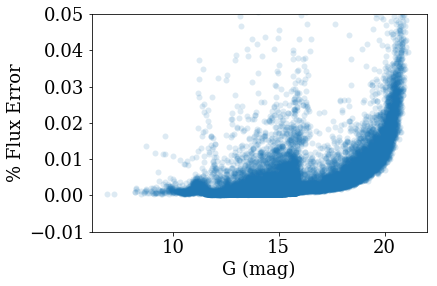

In [8]:
# learn what "good" cuts in Plx and G mag are
plt.scatter(gaia[u'phot_g_mean_mag'], gaia[u'phot_g_mean_flux_error']/gaia[u'phot_g_mean_flux'],
           lw=0, alpha=0.15)
plt.ylim(-.01,.05)
plt.ylabel('% Flux Error')
plt.xlabel('G (mag)')

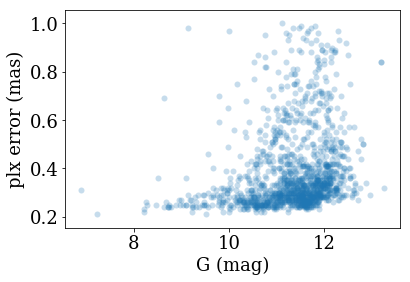

In [9]:
plt.scatter(gaia[u'phot_g_mean_mag'], gaia[u'parallax_error'],
           lw=0, alpha=0.25)
plt.ylabel('plx error (mas)')
plt.xlabel('G (mag)')

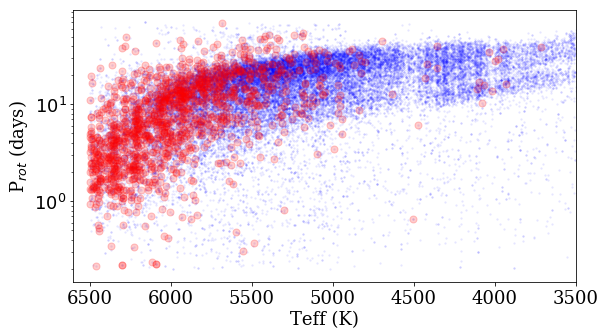

In [10]:
# remake now-famous Kepler gyro diagram
plt.figure(figsize=(9,5))
plt.scatter(gaia[u'Teff'], gaia[u'Prot'], s=5, alpha=0.1, c='blue', lw=0, rasterized=True)
plt.scatter(tgas[u'Teff'], tgas[u'Prot'], s=50, alpha=0.2, c='red', rasterized=True)

plt.xlim(6600, 3500)
plt.yscale('log')
plt.xlabel('Teff (K)')
plt.ylabel('P$_{rot}$ (days)')
# plt.title('Gaia DR1 - McQuillan (2014) xmatch')

# plt.savefig('fig1.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [11]:
# find the "good" stars, with reasonable Plx and Phot errors

ok = np.where(np.isfinite(gaia[u'parallax']) & # this is basically the same as the TGAS file...
              (gaia[u'parallax_error'] < 0.4) &
              (gaia[u'phot_g_mean_flux_error']/gaia[u'phot_g_mean_flux'] < 0.01))

print(len(ok[0]))

894


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10


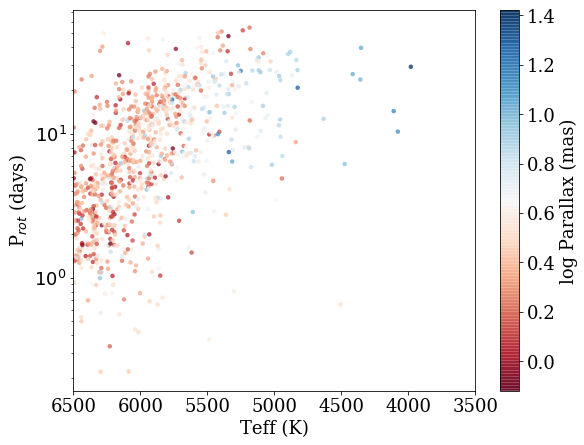

In [12]:
'''
can we explore the bimodality in periods for the M dwarfs?

- NO - ... too few stars with parallax

'''
cm = plt.cm.get_cmap('RdBu')

plt.figure(figsize=(9,7))
plt.scatter(gaia[u'Teff'].values[ok], 
            gaia[u'Prot'].values[ok],
            s=20, alpha=0.75, lw=0, cmap=cm, c=np.log10(gaia[u'parallax'].values[ok]))
plt.xlim(6500,3500)
# plt.ylim(4,100)
plt.yscale('log')
plt.xlabel('Teff (K)')
plt.ylabel('P$_{rot}$ (days)')
cb = plt.colorbar()
cb.set_label('log Parallax (mas)')

In [13]:
# whats up with the "variable" flag in Gaia data? spot range?
np.unique(gaia[u'phot_variable_flag'])

# nevermind....

array(['NOT_AVAILABLE'], dtype=object)

In [14]:
# make an HR diagram of rotation period stars!

Mg = gaia[u'phot_g_mean_mag'] + 5. * np.log10(gaia[u'parallax']/1000.)  + 5

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


## Distances to *Kepler* stars!

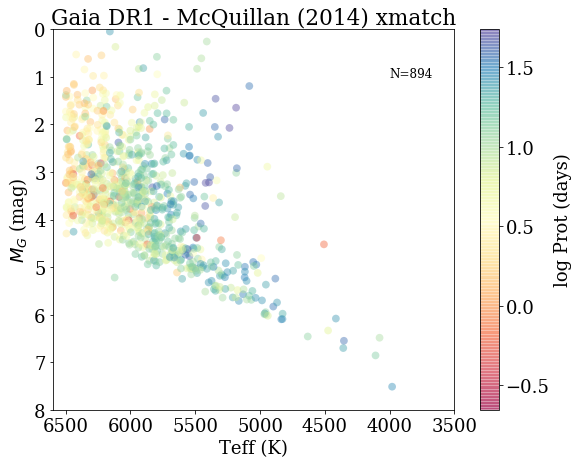

In [15]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(gaia[u'Teff'].values[ok], Mg.values[ok], 
            c=np.log10(gaia[u'Prot'].values[ok]),
            lw=0, alpha=0.45, cmap=cm, s=60)

plt.xlim(6600, 3500)
plt.ylim(8, 0)
plt.xlabel('Teff (K)')
plt.ylabel('$M_G$ (mag)')
plt.title('Gaia DR1 - McQuillan (2014) xmatch')
plt.text(4000, 1, 'N=894', fontsize=12)

cb = plt.colorbar()
cb.set_label('log Prot (days)')

In [16]:
# let's put an ischrone down on that figure...
iso_file1 = 'output661464910329.dat' # Padova isochrone, 0.3gyr
iso_file2 = 'output223087321109.dat' # 1.0Gyr
iso_file3 = 'output816153020438.dat' # 4Gyr

In [17]:
names=('Z','log(age)','M_ini', 'M_act','logL/Lo','logTe','logG','mbol','G','G_BP','G_RP','int_IMF','stage')
iso1 = pd.read_table(iso_file1, delim_whitespace=True, header=None, comment='#', names=names)
iso2 = pd.read_table(iso_file2, delim_whitespace=True, header=None, comment='#', names=names)
iso3 = pd.read_table(iso_file3, delim_whitespace=True, header=None, comment='#', names=names)

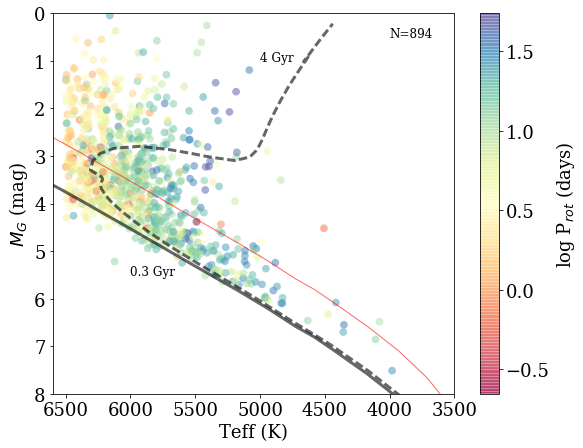

In [18]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(gaia[u'Teff'].values[ok], Mg.values[ok], 
            c=np.log10(gaia[u'Prot'].values[ok]),
            lw=0, alpha=0.5, cmap=cm, s=60, rasterized=False)

ms = np.where((iso1['stage'] <= 1))
plt.plot(10**iso1['logTe'].values[ms], iso1['G'].values[ms], 
         lw=3, alpha=0.6, c='k')

plt.plot(10**iso3['logTe'].values[ms], iso3['G'].values[ms], 
         lw=3, alpha=0.6, c='k', linestyle='dashed')


plt.plot(10**iso1['logTe'].values[ms], iso1['G'].values[ms]-1, 
         lw=1, alpha=0.6, c='r')


plt.text(4000,0.5, 'N='+str(len(ok[0])), fontsize=12)
plt.text(5000, 1, '4 Gyr', fontsize=12)
plt.text(6000, 5.5, '0.3 Gyr', fontsize=12)

plt.xlim(6600, 3500)
plt.ylim(8, 0)
plt.xlabel('Teff (K)')
plt.ylabel('$M_G$ (mag)')
# plt.title('Gaia DR1 - McQuillan (2014) xmatch')


cb = plt.colorbar()
cb.set_label('log P$_{rot}$ (days)')

# plt.savefig('fig2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [19]:
# what is that red outlier at T = 4500 K, M_G = 4.5
ol = np.where((gaia[u'Teff'].values[ok] > 4300) & 
              (gaia[u'Teff'].values[ok] < 4600) & 
              (Mg.values[ok] > 4) & 
              (Mg.values[ok] < 5))
print(gaia[u'KIC'].values[ok][ol])
print(gaia[u'Prot'].values[ok][ol])
print(gaia[u'Teff'].values[ok][ol])
print(Mg.values[ok][ol])

[7957709]
[ 0.652]
[4507]
[ 4.52172169]


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [20]:
# Mg_iso = np.interp(gaia[u'Teff'].values[ok], 10**iso1['logTe'].values[ms], iso1['G_RP'].values[ms])
Mg_iso = np.interp(gaia[u'Teff'].values[ok], 10**iso1['logTe'].values[ms], iso1['G'].values[ms])
delta_mag = Mg_iso - Mg.values[ok]

delta_lim = [0, 1]

/Users/james/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/james/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


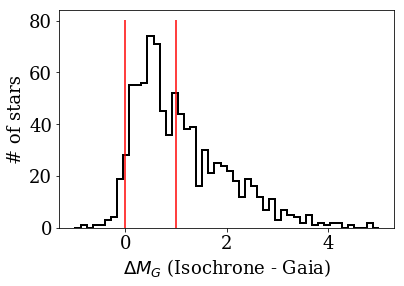

In [21]:
_ = plt.hist(delta_mag, range=(-1,5), bins=50, histtype='step', lw=2, color='k')
plt.xlabel(r'$\Delta M_G$ (Isochrone - Gaia)')
plt.plot([delta_lim[0], delta_lim[0]], [0,80], c='r', lw=2, alpha=0.75)
plt.plot([delta_lim[1], delta_lim[1]], [0,80], c='r', lw=2, alpha=0.75)

plt.ylabel('# of stars')

# plt.savefig('fig3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [22]:
# get stars "near" the isochrone
# NOTE: using the 'red' phot channel, because it looks "better"
msok = np.where((delta_mag >= delta_lim[0]) & 
                (delta_mag <= delta_lim[1]))

print(len(msok[0]))

msbad = np.where((delta_mag > delta_lim[1]))
print(len(msbad[0]))

440
414


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


3.53


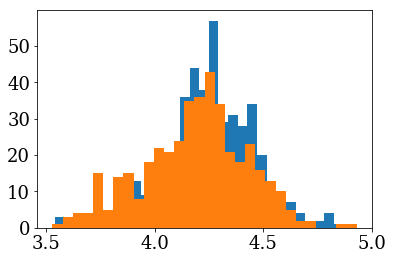

In [23]:
_ = plt.hist(gaia[u'log(g)'].values[ok][msok], bins=30)
_ = plt.hist(gaia[u'log(g)'].values[ok][msbad], bins=30)
print(min(gaia[u'log(g)'].values[ok]))

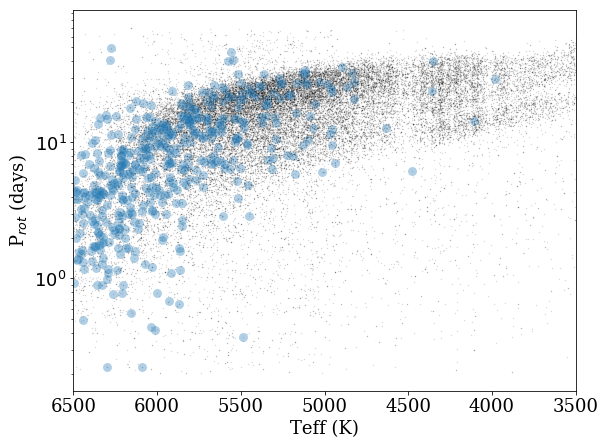

In [24]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')
plt.scatter(gaia[u'Teff'], gaia[u'Prot'], s=2, alpha=0.15, c='k', lw=0, rasterized=True)

# plt.scatter(gaia[u'Teff'].values[ok], 
#             gaia[u'Prot'].values[ok],
#             s=10, alpha=0.5, lw=0, c='k')

plt.scatter(gaia[u'Teff'].values[ok][msok], 
            gaia[u'Prot'].values[ok][msok],
            s=80, alpha=0.35, lw=0, rasterized=True)

plt.xlim(6500,3500)

plt.yscale('log')
plt.xlabel('Teff (K)')
plt.ylabel('P$_{rot}$ (days)')

# plt.title('Stars close to main sequence')

# plt.savefig('fig3raw.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [25]:
def MM09e2(B_V, age):
    ''' 
    Eqn 2 
    http://adsabs.harvard.edu/abs/2009ApJ...695..679M
    '''
    a = 0.50
    b = 0.15
    P = np.sqrt(age) * (np.sqrt(B_V - a)) - b * (B_V - a)
    return P

def MM09e3(B_V, age):
    ''' Eqn 3 '''
    c = 0.77
    d = 0.40
    f = 0.60
    P = age**0.52 * (c * (B_V - d)**f)
    return P

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


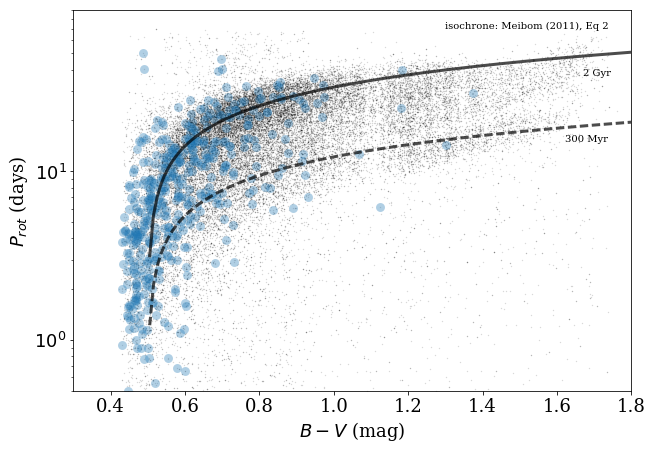

In [26]:
# remake again, but now in B-V units, and with Ruth's isochrone...
B_V = teff2bv(gaia[u'Teff'].values, gaia[u'log(g)'].values, 0)

B_V_iso = np.arange(0.475,2,0.01)
# B_V_iso = np.arange(0.65,2,0.01)
giso1 = gyro(B_V_iso, 500.)
giso2 = gyro(B_V_iso, 3000.)


miso1e2 = MM09e2(B_V_iso, 300)
# miso1e3 = MM09e3(B_V_iso, 500)
miso2e2 = MM09e2(B_V_iso, 2000)
# miso2e3 = MM09e3(B_V_iso, 2000)



plt.figure(figsize=(10,7))
cm = plt.cm.get_cmap('Spectral')
plt.scatter(B_V, gaia[u'Prot'], s=2, alpha=0.15, c='k', lw=0)

plt.scatter(B_V[ok][msok], 
            gaia[u'Prot'].values[ok][msok],
            s=80, alpha=0.35, lw=0)

# plt.plot(B_V_iso, giso1, c='orange', alpha=0.7, lw=3)
# plt.plot(B_V_iso, giso2, c='red', alpha=0.7, lw=3)
# plt.text(1.62, 9, '500 Myr', fontsize=10)
# plt.text(1.67, 27, '3 Gyr', fontsize=10)


plt.plot(B_V_iso, miso1e2, c='k', alpha=0.7, lw=3,linestyle='dashed')
plt.plot(B_V_iso, miso2e2, c='k', alpha=0.7, lw=3)
plt.text(1.62, 15, '300 Myr', fontsize=10)
plt.text(1.67, 37, '2 Gyr', fontsize=10)

plt.text(1.3, 70, 'isochrone: Meibom (2011), Eq 2', fontsize=10)


plt.xlim(0.3,1.8)
plt.ylim(0.5,90)

plt.yscale('log')
plt.xlabel('$B-V$ (mag)')
plt.ylabel('$P_{rot}$ (days)')

# plt.title('Stars close to main sequence')

# plt.savefig('gyrochrones.png', bbox_inches='tight', pad_inches=0.25)

In [27]:
# # emulate the classic McQuillan stacked histogram plot
# plt.figure(figsize=(10,7))
# plt.scatter(gaia[u'Teff'].values[ok][msok], 
#             np.log10(gaia[u'Prot'].values[ok][msok]),
#             s=80, alpha=0.35, lw=0, rasterized=True)

# bsize = 300 # in Teff
# Nbins = (np.max(gaia[u'Teff'].values[ok][msok]) - np.min(gaia[u'Teff'].values[ok][msok])) / bsize + 1

# Npbins = 25 #np.int(5 + np.floor(len(x[0])/4.))
# pbins = np.linspace(-1, 2, Npbins)

# for k in range(Nbins):
#     x = np.where((gaia[u'Teff'].values[ok][msok] >= k*bsize + np.min(gaia[u'Teff'].values[ok][msok])) & 
#                  (gaia[u'Teff'].values[ok][msok] <= k*bsize + np.min(gaia[u'Teff'].values[ok][msok]) + bsize))

#     if len(x[0]) > 0:
#         yhist, bin_edges = np.histogram(np.log10(gaia[u'Prot'].values[ok][msok][x]), bins=pbins)
        
#         xoff = np.float((k+1)*bsize + np.min(gaia[u'Teff'].values[ok][msok]))
#         plt.plot(-yhist*bsize/np.nanmax(yhist)*0.95 + xoff, 
#                  (bin_edges[1:]+bin_edges[0:-1])/2., c='k', lw=2, alpha=0.75)

# plt.xlim(6900,3500)
# plt.ylim(-1,2)

# plt.xlabel('Teff (K)')
# plt.ylabel('log $P_{rot}$ (days)')
# plt.title('Stars close to main sequence')

In [28]:
# some more functions...

def EqBins(obj, N):
    '''
    Return edges for N bins from numpy array obj with equal numbers of items
    
    (returns N+1 edges)
    '''
    Npts = np.floor(len(obj) / N)
    ss = np.argsort(obj)    
    xx = np.array(np.arange(N)*Npts, dtype='int')
    edges = np.hstack((obj[ss][xx], np.max(obj)))
    return edges

def _tau(mass):
    '''
    Write up the Eqn 11 from Wright (2011) that gives the
    convective turnover timescale, used in Rossby number calculation

    (Ro = Prot / tau)

    Parameters
    ----------
    mass : float
        relative to solar

    Returns
    -------
    tau (in days)

    '''
    log_tau = 1.16 - 1.49 * np.log10(mass) - 0.54 * np.log10(mass)**2.
    return  10.**log_tau

In [29]:
# read in Table 1 from Barnes & Kim (2010)
bknames = ('M', 'logT', 'LLsun', 'Age', 'tau_g', 'tau_l', 'CC', 'RZ', 'CE', 'Tot', 
           'U','B','V','R','I','J','H','K','Ug','Bg','Vg','Rg','Ig')
bk = pd.read_table('apj364262t1_ascii.txt', delim_whitespace=True, header=None, comment='#', names=bknames)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


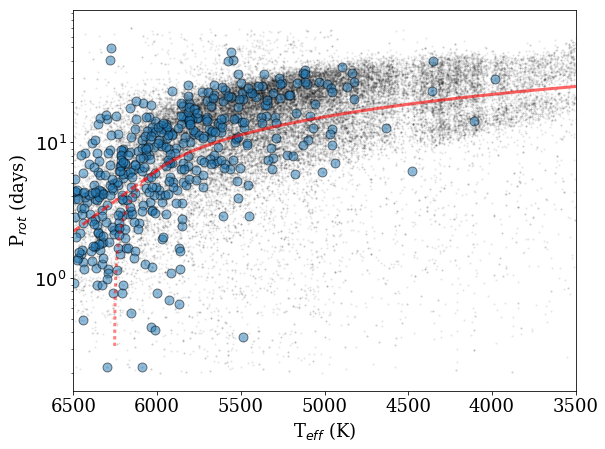

In [54]:
# make gyro plot again, but put isochrones on in Teff units
B_V = teff2bv(gaia[u'Teff'].values, np.median(gaia[u'log(g)'].values), 0)
ss = np.argsort(B_V)
sb = np.argsort(gaia[u'Teff'].values)
mid_iso = MM09e2(B_V, 600)


#####
plt.figure(figsize=(9,7))
# cm = plt.cm.get_cmap('Spectral')
plt.scatter(gaia[u'Teff'], gaia[u'Prot'], s=4, alpha=0.1, c='k', lw=0, rasterized=True)

plt.scatter(gaia[u'Teff'].values[ok][msok], 
            gaia[u'Prot'].values[ok][msok],
            s=80, alpha=0.5, lw=1, rasterized=True, edgecolors='k')

# add lines of constant Rossby number
# ms = np.where((iso1['stage'] <= 1))
# for Ro in [0.01, 0.1, 1, 10]:
#     plt.plot(10.**iso1['logTe'].values[ms], 
#              (Ro * _tau(iso1['M_ini'].values[ms])),
#              lw=3, alpha=0.6, c='orange')


# plot the isochrone
iok = np.where((gaia[u'Teff'].values[sb] < 6000) & (gaia[u'Teff'].values[sb] > 3500))
nok = np.where((gaia[u'Teff'].values[sb] > 6000))
plt.plot(gaia[u'Teff'].values[sb][iok], mid_iso[sb][iok], c='red', lw=3, alpha=0.6, rasterized=True)
plt.plot(gaia[u'Teff'].values[sb][nok], mid_iso[sb][nok], c='red', lw=3, alpha=0.5, linestyle='dotted', rasterized=True)

# extend the isochrone by hand
xx = gaia[u'Teff'].values[sb][iok]
yy = np.log10(mid_iso[sb][iok])
bpoint = -20
m = (yy[bpoint] - yy[-1]) / (xx[bpoint] - xx[-1])
b = yy[-1] - m*xx[-1]
# plot the isochrone extension
plt.plot(np.arange(6000,6600,100), 10.**(np.arange(6000,6600,100)*m+b), 
         c='red', lw=3, alpha=0.6, linestyle='dashed', rasterized=True)

# plot the Barnes & Kim (2010) line of constant Rossby # @ 500Myr
# plt.plot(10.**bk['logT'], bk['tau_g']*0.1, c='yellow')
# plt.plot(10.**bk['logT'], bk['tau_l']*0.5, c='green')

plt.xlim(6500,3500)
plt.yscale('log')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('P$_{rot}$ (days)')

plt.savefig('fig3_mod.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [31]:
# combine and re-sample the modified isochrone to the same as the blue (final) data

red_Tx = np.hstack((np.arange(6000,6600,100), gaia[u'Teff'].values[sb][iok]))
red_Px = np.hstack((10.**(np.arange(6000,6600,100)*m+b), mid_iso[sb][iok]))

rs = np.argsort(red_Tx)
red_Tx = red_Tx[rs]
red_Px = red_Px[rs]

red_P = np.interp(gaia[u'Teff'].values[ok][msok], red_Tx, red_Px)
red_P_ok = np.interp(gaia[u'Teff'].values[ok], red_Tx, red_Px)

('# of stars in blue: ', (1, 440))


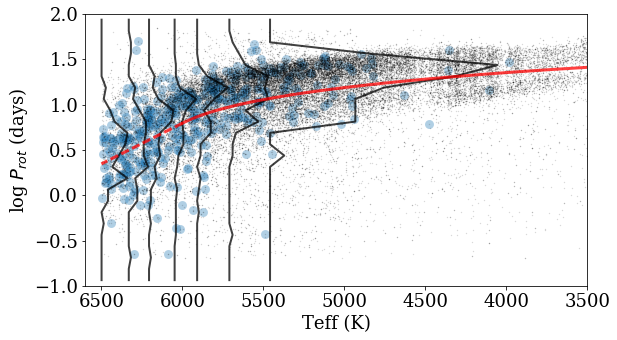

In [32]:
# emulate the classic McQuillan stacked histogram plot, now with equal number star bins
plt.figure(figsize=(9,5))
plt.scatter(gaia[u'Teff'].values[ok][msok], 
            np.log10(gaia[u'Prot'].values[ok][msok]),
            s=80, alpha=0.35, lw=0)
print('# of stars in blue: ', np.shape(msok))

plt.scatter(gaia[u'Teff'], np.log10(gaia[u'Prot']), s=2, alpha=0.15, c='k', lw=0, rasterized=True)

Nbins = 7
Tbins = EqBins(gaia[u'Teff'].values[ok][msok], Nbins)

pbins = np.linspace(-1, 2, 25)

for k in range(Nbins):
    x = np.where((gaia[u'Teff'].values[ok][msok] >= Tbins[k]) & 
                 (gaia[u'Teff'].values[ok][msok] <= Tbins[k+1]))
    
    if len(x[0]) > 0:
        yhist, bin_edges = np.histogram(np.log10(gaia[u'Prot'].values[ok][msok][x]), bins=pbins)
        
        bsize = np.float(Tbins[k+1] - Tbins[k])
        plt.plot(-yhist*bsize/np.nanmax(yhist)*0.95 + Tbins[k+1], 
                 (bin_edges[1:]+bin_edges[0:-1])/2., c='k', lw=2, alpha=0.75)
        

plt.xlim(6600,3500)
plt.ylim(-1,2)

plt.plot(gaia[u'Teff'].values[sb][iok], np.log10(mid_iso[sb][iok]), c='red', lw=3, alpha=0.75)
plt.plot(np.arange(6000,6600,100), (np.arange(6000,6600,100)*m+b), c='red', lw=3, alpha=0.75, linestyle='dashed')

plt.xlabel('Teff (K)')
plt.ylabel('log $P_{rot}$ (days)')


In [33]:
# now count how many stars are above or below this "mid-point isochrone"
above = np.where((gaia[u'Prot'].values[ok][msok] > red_P)) 
below = np.where((gaia[u'Prot'].values[ok][msok] <= red_P)) 
print('above: ',np.shape(above[0]), 'below: ', np.shape(below[0]))

('above: ', (262,), 'below: ', (178,))


In [34]:
def _gaus1(x, a1, x1, sig1):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)))
    return f

def _gaus2(x, a1, x1, sig1, a2, x2, sig2):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)) + 
         a2 * np.exp(-(x - x2)**2 / (2 * sig2**2)) )
    return f

def _gaus3(x, a1, x1, sig1, a2, x2, sig2, a3, x3, sig3):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)) + 
         a2 * np.exp(-(x - x2)**2 / (2 * sig2**2)) +
         a3 * np.exp(-(x - x3)**2 / (2 * sig3**2)))
    return f

(-0.19421230522000543, 0.2113330654270402)
(0.011029656198393007, 0.008801255324308704)


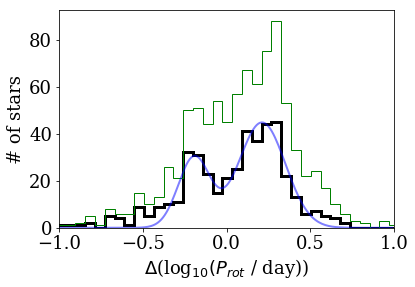

In [35]:
yy, xx, _ = plt.hist(np.log10(gaia[u'Prot'].values[ok][msok]) - np.log10(red_P), 
                     bins=45, histtype='step', lw=3, color='k')

_ = plt.hist(np.log10(gaia[u'Prot'].values[ok]) - np.log10(red_P_ok), 
             bins=45, histtype='step', lw=1, color='g')



p2 = [32, -0.25, 0.01, 45, 0.25, 0.01]
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))

dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=2, alpha=0.5, c='blue')

p3 = [32, -0.25, 0.01, 45, 0.25, 0.01, 10, -0.1, 0.3]
popt3, pcov = curve_fit(_gaus3, bcent, yy, p0=p3)

# plt.plot(dprot, _gaus3(dprot, *popt3), lw=2, alpha=0.5, c='red')

# plt.plot(dprot, _gaus1(dprot, popt3[0], popt3[1], popt3[2]))
# plt.plot(dprot, _gaus1(dprot, popt3[3], popt3[4], popt3[5]))
# plt.plot(dprot, _gaus1(dprot, popt3[6], popt3[7], popt3[8]))

plt.xlim(-1,1)
plt.xlabel(r'$\Delta$(log$_{10} (P_{rot}$ / day))')
plt.ylabel('# of stars')

# plt.savefig('fig4.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

print(popt2[1], popt2[4])
print(perr2[1], perr2[4])

In [36]:
def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / data.size

def BIC(data, error, model, p):
    x2 = chisq(data, error, model)
    return x2 + p.size * np.log(data.size) 

# compare BIC for the 2 vs 3 gauss model
bic2 = BIC(yy, _gaus2(bcent, *popt2), 1., popt2)
bic3 = BIC(yy, _gaus3(bcent, *popt3), 1., popt3)

print(bic2, bic3) # so the 3-gaus model is preferred

(3.7365375724685124e+52, 644.65862706640314)


# Distances

In [37]:
# can we estimate the space volume covered by A) the TGAS-matched MS sample, and 
# B) the K/M stars that show the bimodality from McQuillan?

# K/M stars, use isochrone and gaia[u'phot_g_mean_mag'] to estimate photometric distance
km = np.where((gaia[u'Teff'] < 4000))
ms = np.where((iso1['stage'] <= 1))
km_Mg = np.interp(gaia[u'Teff'].values[km], 
                  10**iso1['logTe'].values[ms], iso1['G'].values[ms])
# distance mod. (m-M)
DM_km = gaia[u'phot_g_mean_mag'].values[km] - km_Mg
dist_km = 10.**((DM_km + 5) / 5)

# now (easy) compute for TGAS-matched hotter stars
DM_tgas = -5 + 5 * np.log10(1000. / gaia[u'parallax'].values[ok][msok])
dist_tgas = 1000. / gaia[u'parallax'].values[ok][msok]

('K/M median: ', 216.7229044767673)
('TGAS median: ', 285.30728530728533)


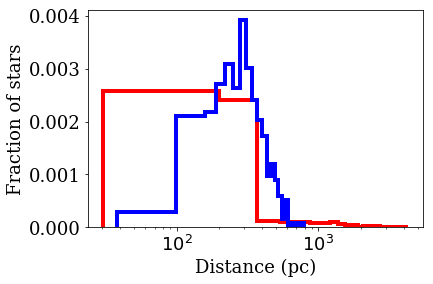

In [38]:
_ = plt.hist(dist_km, color='red', normed=True, histtype='step', bins=25, lw=4)
_ = plt.hist(dist_tgas, color='blue', normed=True, histtype='step', bins=25, lw=4)
plt.xscale('log')
plt.xlabel('Distance (pc)')
plt.ylabel('Fraction of stars')

print('K/M median: ', np.median(dist_km))
print('TGAS median: ', np.median(dist_tgas))

In [39]:
# # now a plot of distance modulous 
# _ = plt.hist(DM_km, color='red', normed=True, histtype='step', bins=25, lw=4)
# _ = plt.hist(DM_tgas, color='blue', normed=True, histtype='step', bins=25, lw=4)
# plt.xlabel('m - M (mag)')
# plt.ylabel('Fraction of stars')

# print('K/M median: ', np.median(DM_km))
# print('TGAS median: ', np.median(DM_tgas))

hmmm...

There's only enough targets to go out to under 800pc, and really only in 2 distance bins

what we CAN say is at least in these 2 distance bins there's no significant difference in the rotation. However, the distance distribution is stronly peaked under 400pc, so very few stars between 400 and 800pc, and thus not a good test at far distances

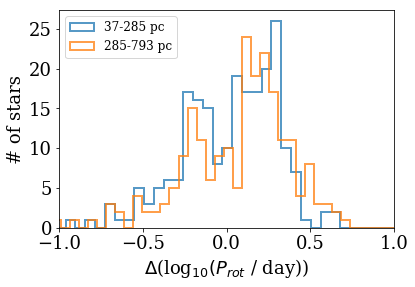

In [40]:
# make the period distribution plot as a function of distance (3 bins?)

dbins = EqBins(dist_tgas, 2)

for k in range(dbins.size-1):
    xk = np.where((dist_tgas >= dbins[k]) & (dist_tgas <= dbins[k+1]))
    
    _ = plt.hist(np.log10(gaia[u'Prot'].values[ok][msok][xk]) - np.log10(red_P[xk]), bins=45,
                 histtype='step', lw=2, alpha=0.75, label=str(int(dbins[k]))+'-'+str(int(dbins[k+1]))+' pc')
plt.legend(loc='upper left', fontsize=12)

plt.xlim(-1,1)
plt.xlabel(r'$\Delta$(log$_{10} (P_{rot}$ / day))')
plt.ylabel('# of stars')

plt.savefig('2dist_bins.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

# Proper Motions

('median above: ', 15.373856668858519)
('median below: ', 11.301950163653459)
('median PM error:', 1.4275539188520987)
('diff / error = ', 2.8523661708548951)


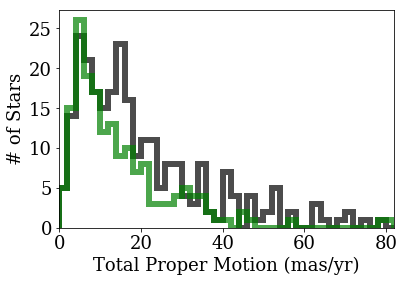

In [41]:
# now recreate the proper motion histogram, Fig 13 from McQuillan (2013)
above = np.where((gaia[u'Prot'].values[ok][msok] > red_P)) 
below = np.where((gaia[u'Prot'].values[ok][msok] <= red_P)) 

total_pm = np.sqrt((gaia[u'pmra'].values[ok][msok])**2 + (gaia[u'pmdec'].values[ok][msok])**2)
total_pm_err = np.sqrt((gaia[u'pmra_error'].values[ok][msok])**2 + (gaia[u'pmdec_error'].values[ok][msok])**2)

y1,x1,_ = plt.hist(total_pm[above], color='black', histtype='step', bins=np.arange(0,100,2), lw=6, alpha=0.7)
y2,x2,_ = plt.hist(total_pm[below], color='green', histtype='step', bins=np.arange(0,100,2), lw=6, alpha=0.7)

# plt.vlines(np.median(total_pm[above]), 0, 30, lw=3, alpha=0.75, linestyle='dashed')
# plt.vlines(np.median(total_pm[below]), 0, 30, lw=3, alpha=0.75, color='green', linestyle='dashed')

plt.xlim(0, 82)
plt.xlabel('Total Proper Motion (mas/yr)')
plt.ylabel('# of Stars')


print('median above: ', np.median(total_pm[above]))
print('median below: ', np.median(total_pm[below]))
print('median PM error:', np.median(total_pm_err))

print('diff / error = ', (np.median(total_pm[above]) - np.median(total_pm[below])) / np.median(total_pm_err))

# plt.savefig('fig5a.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

(-1, 1)

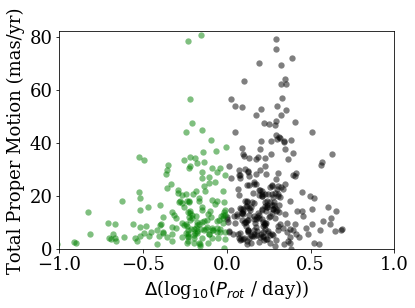

In [42]:
plt.figure()
plt.scatter(np.log10(gaia[u'Prot'].values[ok][msok][above]) - np.log10(red_P[above]), total_pm[above], 
            c='k', alpha=0.5, cmap=cm, s=40, lw=0, rasterized=True)
plt.scatter(np.log10(gaia[u'Prot'].values[ok][msok][below]) - np.log10(red_P[below]), total_pm[below], 
            c='green', alpha=0.5, cmap=cm, s=40, lw=0, rasterized=True)
plt.ylabel('Total Proper Motion (mas/yr)')
# plt.xlabel('P$_{rot}$ (days)')
plt.xlabel(r'$\Delta$(log$_{10} (P_{rot}$ / day))')

plt.ylim(0, 82)
plt.xlim(-1,1)
# plt.savefig('fig5b.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

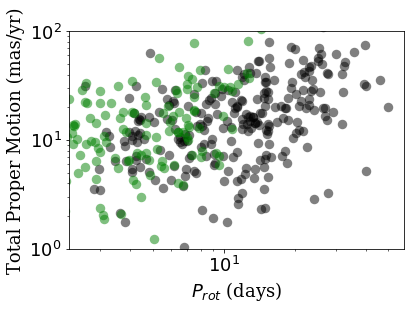

In [43]:
plt.figure()
plt.scatter((gaia[u'Prot'].values[ok][msok][above]), total_pm[above], 
            c='k', alpha=0.5, cmap=cm, s=90, lw=0, rasterized=True)
plt.scatter((gaia[u'Prot'].values[ok][msok][below]), total_pm[below], 
            c='g', alpha=0.5, cmap=cm, s=90, lw=0, rasterized=True)
plt.ylabel('Total Proper Motion (mas/yr)')
# plt.xlabel('P$_{rot}$ (days)')
plt.xlabel('$P_{rot}$ (days)')

plt.yscale('log')
plt.ylim(1,100)
plt.xscale('log')
# plt.savefig('fig5b.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [44]:
# do KS test of 2 PM populations
stats.ks_2samp(y1,y2)

Ks_2sampResult(statistic=0.1428571428571429, pvalue=0.66522907070121162)

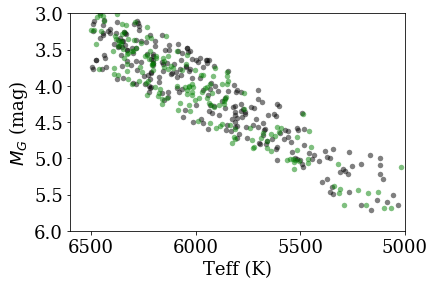

In [45]:
# make HR diagram for stars above/below isochrone
plt.scatter(gaia[u'Teff'].values[ok][msok][above], Mg.values[ok][msok][above], 
            c='k', lw=0, alpha=0.5, cmap=cm, s=30,  rasterized=True)
plt.scatter(gaia[u'Teff'].values[ok][msok][below], Mg.values[ok][msok][below], 
            c='g', lw=0, alpha=0.5, cmap=cm, s=30,  rasterized=True)
plt.xlim(6600, 5000)
plt.ylim(6, 3)
plt.xlabel('Teff (K)')
plt.ylabel('$M_G$ (mag)')



# Subgiants

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide


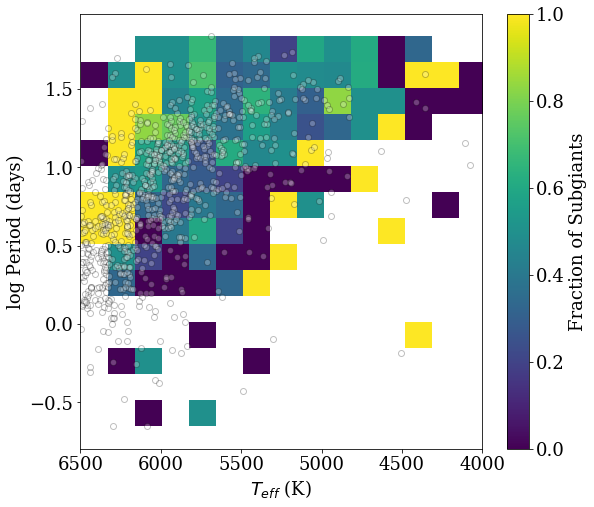

In [46]:
# try to match plot that J. van Saders sent, predicting fraction of subgiants as function of color & period
subg = delta_mag >= delta_lim[1]
NBins=15

H1, xe, ye = np.histogram2d(gaia[u'Teff'].values[ok], np.log10(gaia[u'Prot'].values[ok]), 
                            weights=subg, bins=NBins)
H2, xe, ye = np.histogram2d(gaia[u'Teff'].values[ok], np.log10(gaia[u'Prot'].values[ok]), 
                            bins=NBins)


plt.figure(figsize=(9,8))
plt.imshow(H1/H2, interpolation='nearest', origin='low', extent=[xe[0], xe[-1], ye[0], ye[-1]], aspect='auto')
cb = plt.colorbar()
cb.set_label('Fraction of Subgiants')

plt.scatter(gaia[u'Teff'].values[ok], np.log10(gaia[u'Prot'].values[ok]), c='white', alpha=0.25, edgecolors='k')

plt.xlim(6500,4000)
plt.xlabel('$T_{eff}$ (K)')
plt.ylabel('log Period (days)')

## Thoughts

- we will get almost ALL the Kepler rotation sample in the final Gaia data... just not today
- are we actually grabbing stars near the main sequence?
- could we identify binary systems and remove them?
- is this trimmed down Prot plot useful for redefining gyro relations?